<a href="https://colab.research.google.com/github/kanishkatks/BERT-fine-tuning/blob/main/BERT_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning

### The Data

To get started, we're going to load up this [csv](https://wagon-public-datasets.s3.amazonaws.com/imdb.csv) of 8000 IMDB reviews that we're going to be using throughout this exercise.

In [6]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/imdb.csv' # set your own path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

df = pd.read_csv(data_path)

print(df["text"][0])
print(df["label"][0])

Ouch! They don't come much worse than this horrid adaptation of C. S. Lewis's beloved novel. While the adaptation is very true to the novel, the acting is simply awful and the sets and special effects are on a scale equivalent to a school play. I've read that the budget for this miniseries was the grandest that the BBC has ever given at the time, but surely they could have scraped together a bit more than the $2 that it looks like this was filmed for. The worst effect of all is Mr. Beaver. I know computer effects weren't at the level necessary or even cost effective at the time, but the costume store man in a suit look was horrid. Better to have just cut the character from the film than do that to the role! Avoid this at all costs.
0


Plot a histogram of the lengths of each reviews so we can get a sense of how they are distributed

<Axes: >

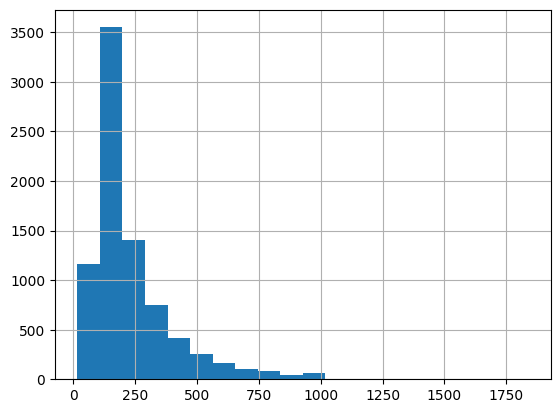

In [8]:
df["len"] = df["text"].map(lambda x: len(x.split()))
df["len"].hist(bins = 20)


So - we have a lot of reviews - most around the 150-250 word length - and those reviews have a lot of messy punctiation. We will useHuggingFace library provides us with `AutoTokenizers` for tokenization.

Throughout this notebook, we're going to be working with the `bert-tiny` model from HuggingFace.

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/tok_emb.png" width = 550px>

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/tok_emb_bad.png" width = 550px>

Instantiate an `AutoTokenizer.from_pretrained()` from HuggingFace that corresponds to the `prajjwal1/bert-tiny` model.


In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny", padding_side = "right")
tokenizer("My tokenizers and model must match")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

{'input_ids': [101, 2026, 19204, 17629, 2015, 1998, 2944, 2442, 2674, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
llama_tokenizer = AutoTokenizer.from_pretrained("TheBloke/llama-2-70b-Guanaco-QLoRA-fp16")

llama_tokenizer("My tokenizers and model must match")


tokenizer_config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

{'input_ids': [1, 1619, 5993, 19427, 322, 1904, 1818, 1993], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

### So how can we use a BERT model?

Now that we've explored tokenization, we need to think about how we go from our tokens to somehow getting out a classification of "positive" or "negative" and to do that we need to talk about BERT.

BERT gets trained via "semi-supervised" learning to predict the missing word in a sentence, looking both to its left and right as its context (hence it is named a "bidirectional" encoder). This means that it can see everything on either side of the masked word below.

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/bert_workings.png" width = 350px>



Over time, BERT gets great at filling in the blank - in this case it learns that the word "over" should go here! Let's take a look at some architectures:

<img src = https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/13789bert_architecture.png width = 500px>

It's literally just an encoder (or the left side of the model we covered in the lecture! GPT is the right side of the model). During training, they add a few Feed Forward layers and a Softmax layer to make the model try to predict the most likely word blanked out:


<img src = https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/transformers_enc_de_bert.png width = 600px>


__"But why does all of this matter? We're not trying to predict a next word here!", you ask!__ Well, because through learning to fill in the blanks millions of times on large datasets, BERT gets a __really__ good understanding of what words mean and how sentences fit together and produces __fantastic, context-aware__ embeddings.



<img src = https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/bert_good_embeddings_2.png width = 400px>

This is when BERT can become valuable to us - once it's been pre-trained - since we can now take those embedding and use them as __features__ for other tasks.

### Using BERT

Use [`TFAutoModel`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel) to load up a `tiny-bert` model.

N.B. HuggingFace lets us load models that were coded in other Deep Learning libraries (like PyTorch), but if we want to use them like we would use a normal TF model, we can pass `from_pt = True`.

In [12]:
from transformers import TFAutoModel
model = TFAutoModel.from_pretrained("prajjwal1/bert-tiny", from_pt = True)


pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [13]:
tensor_token = tokenizer("My tokenizers and model must match", return_tensors="tf")


We're now going to pass these into our `model`. Pass your `input_ids` into `model.predict()` method to see what embeddings the model predicts from your input tensor!


In [14]:
import tensorflow as tf
# Get individual tensors from the batch
input_tensor = tensor_token['input_ids']


# Pass tokenized input through the model
outputs = model.predict(input_tensor)


1/1 [==============================] - 7s 7s/step


In [15]:
input_tensor.shape

TensorShape([1, 10])

The part we care about most is the `last_hidden_state` array from our prediction. This contains all of our embeddings from the final layer of the BERT model. What is its shape? What does each aspect of the shape signify?

In [16]:

outputs.last_hidden_state.shape


(1, 10, 128)

In [17]:
small_model = TFAutoModel.from_pretrained("prajjwal1/bert-small", from_pt = True)
small_model.predict(input_tensor).last_hidden_state.shape

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

1/1 [==============================] - 2s 2s/step


(1, 10, 512)

In [19]:

outputs.last_hidden_state[:,0,:].shape


(1, 128)

### Tokenizing all our sentences

We want to tokenize all of the cells in our "text" column at once. Before we do though, we need to think about padding. Because we're using subwork tokenization, we can't simply pad/ truncate our words when they are written out in full text.

We'll need to go through each sentence in our DataFrame and see how long it is when tokenized (we can do this by mapping/ applying a function on our DataFrame that tokenizes our sentences). Then we can simply do a quick histogram to see what our varying lengths look like.

<Axes: >

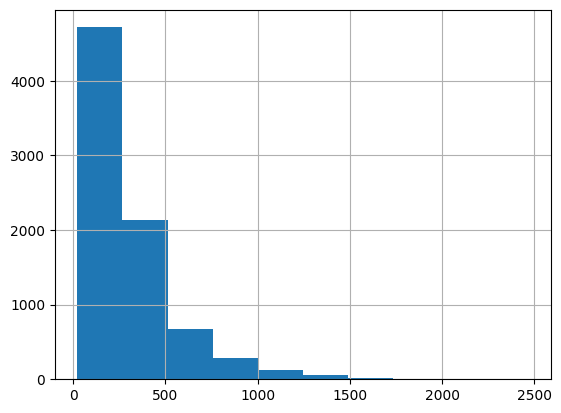

In [20]:
df["tokenized"] = df["text"].map(lambda x: tokenizer(x)["input_ids"])

df["len_tokenized"] = df["tokenized"].map(lambda x: len(x))

df["len_tokenized"].hist()

Looking at our histogram, 500 seems like a reasonable choice.

Let's go ahead and tokenize our column - specify your `"max_length"` as 500 and make sure you enable padding as you call your tokenizer. To get this to work properly, you'll also need to set a value of `True` for the `truncation` arguments and you'll need to make sure you set `padding` equal to `"max_length"`. To ensure the model gets the right kind of input, you will have to add `.tolist()` when you pass your column into your tokenizer.

In [21]:
tokenized_tensors = tokenizer(df["text"].tolist(), max_length=500, padding = "max_length", truncation = True, return_tensors="tf")


What do we get out? What shape do its components have?


In [22]:
tokenized_tensors["input_ids"].shape


TensorShape([8000, 500])

Again, we're just interested in our `input_ids` for now (we won't worry about the attention mask). So grab those and use `model.predict()` to see what embeddings we get out for all of our tokenized sentences.

In [23]:
embeddings = model.predict(tokenized_tensors["input_ids"])


250/250 [==============================] - 220s 871ms/step


### Reducing our data

We finally have all of our sentence embeddings - 128 numbers to express each of our words in their context. This might be quite a lot of data for a model to process (especially if we were to scale up) so we'll simply take the embedding corresponding to the `[CLS]` token (i.e. the first token of your sequence).


<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/CLS_token_explanation.png"> Select this column from your `last_hidden_state` and assign it to `X` since this is what we're going to use in our Classification Neural Network.

In [24]:
X = embeddings.last_hidden_state[:,0,:]


Now, create a train-test split, and train a simple Dense Network to classify between positive and negative reviews. Train it, then evaluate your model on the test set. What kind of accuracy do you get?

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df["label"])

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

input_shape = (128,)

dense_model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(1, activation='sigmoid')
])

dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dense_model.fit(X_train, y_train, validation_split=0.2, epochs=20)

dense_model.evaluate(X_test, y_test)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6151 - loss: 0.6541 - val_accuracy: 0.6758 - val_loss: 0.5915
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7243 - loss: 0.5511 - val_accuracy: 0.7175 - val_loss: 0.5563
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7438 - loss: 0.5235 - val_accuracy: 0.7300 - val_loss: 0.5438
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7511 - loss: 0.5126 - val_accuracy: 0.7242 - val_loss: 0.5465
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7493 - loss: 0.5063 - val_accuracy: 0.7050 - val_loss: 0.5721
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7480 - loss: 0.5058 - val_accuracy: 0.7292 - val_loss: 0.5467
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7629 - loss: 0.4926 - val_accuracy: 0.7092 - val_loss: 0.5768
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7593 - loss: 0.4885 - val_accuracy: 0.7400 - val_

[0.5523508787155151, 0.7360000014305115]

### Fine tuning a BERT model for our task

We've just been using the weights that were achieved by training the model on its training dataset, but the interpretation that the BERT model might have for each word could be different.





<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/Transformers/bert_weight_updating_2.png">

This is exactly what __fine-tuning__ is and HuggingFace makes it really easy 😇

Create another `tiny-bert` model, loading it up with [`TFAutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodelforsequenceclassification) this time instead.

In [26]:
from transformers import TFAutoModelForSequenceClassification

tuning_model = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", from_pt = True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
X_train = tokenized_tensors["input_ids"][:6400]
X_test = tokenized_tensors["input_ids"][6400:]
y_train = df["label"][:6400]
y_test = df["label"][6400:]


In [28]:

tuning_model.compile(optimizer= "adam", metrics= "accuracy")
tuning_model.fit(tokenized_tensors["input_ids"], df["label"], validation_split=0.2, batch_size=32, epochs=5)

tuning_model.evaluate(X_test, y_test)


Epoch 1/5
200/200 [==============================] - 594s 3s/step - loss: 0.6706 - accuracy: 0.5595 - val_loss: 0.5790 - val_accuracy: 0.7312
Epoch 2/5
200/200 [==============================] - 568s 3s/step - loss: 0.5344 - accuracy: 0.7473 - val_loss: 0.5355 - val_accuracy: 0.7494
Epoch 3/5
200/200 [==============================] - 567s 3s/step - loss: 0.4847 - accuracy: 0.7834 - val_loss: 0.4884 - val_accuracy: 0.7825
Epoch 4/5
200/200 [==============================] - 567s 3s/step - loss: 0.3924 - accuracy: 0.8367 - val_loss: 0.4959 - val_accuracy: 0.7738
Epoch 5/5
50/50 [==============================] - 38s 755ms/step - loss: 0.6065 - accuracy: 0.7700


[0.6065389513969421, 0.7699999809265137]

In [29]:

optimizer = tf.optimizers.Adam(learning_rate=0.1)
fast_model = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", from_pt = True)

fast_model.compile(optimizer=optimizer, metrics= "accuracy")
fast_model.fit(tokenized_tensors["input_ids"], df["label"], validation_split=0.2, batch_size=32, epochs=2)

fast_model.evaluate(X_test, y_test)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
200/200 [==============================] - 564s 3s/step - loss: 1.3416 - accuracy: 0.4994 - val_loss: 2.1063 - val_accuracy: 0.5019
Epoch 2/2
50/50 [==============================] - 38s 757ms/step - loss: 0.7608 - accuracy: 0.5019


[0.7608223557472229, 0.5018749833106995]


### Some important notes:

- We're getting good results with this model but this is a *tiny* version of BERT. If we increased the size of our model and if we used our full dataset (rather than just 5000 samples), we might get even better results.

- One downside of fine-tuning (as you have seen) is that it can take a LOT of computational power to carry out. Imagine how much more it might take if we didn't start off with our transfer-learned weights.

- Because of that, in can be important to consider other options first - if you'd like, try training a regular ML Tfidf model and you may be surprised how good the results are. When we're dealing with tasks like classification, __ML will often do a pretty good job with much less compute!__

- That said, there are a __very wide__ range of use cases for BERT-style models - we've only done classification here! Look around HuggingFace and you'll see all sorts of fine-tuned BERTs for specific domains (e.g. Finance, medicine or Twitter) and different tasks (some that ML can't help us with)

- Each BERT model can be fine-tuned as long as you take the proper time to structure your data correctly (especially using Data Loaders like the Tensorflow Dataset if your data is very large).
